In [1]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle

## Get MFCC function

In [2]:
# read file
def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
    hop_length = math.floor(sr*0.010) # 10ms hop
    win_length = math.floor(sr*0.025) # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y, sr, n_mfcc=12, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 36 (transpose of X)
    return X.T # hmmlearn use T x N matrix

## lấy mfcc của tất cả các file trong dir

In [3]:
# lấy mfcc của tất cả các file wav trong wav
def get_class_data(data_dir):
    files = os.listdir(data_dir)
    mfcc = [get_mfcc(os.path.join(data_dir,f)) for f in files if f.endswith(".wav")]
    return mfcc

## Hàm Clustering

In [4]:
def clustering(X, n_clusters=14):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0, verbose=0)
    kmeans.fit(X)
    print("centers", kmeans.cluster_centers_.shape)
    return kmeans

## plot biểu đồ predict/true

In [5]:
def plotCM(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('test')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

## Data

In [6]:
class_names = ['len', 'xuong', 'trai', 'phai']
dataset = {}
for cname in class_names:
    print(f"Load {cname} dataset")
    dataset[cname]=get_class_data(os.path.join('data',cname))

Load len dataset
Load xuong dataset
Load trai dataset
Load phai dataset


In [7]:
print(len(dataset['len']))
print(len(dataset['xuong']))
print(len(dataset['trai']))
print(len(dataset['phai']))

77
77
77
77


In [8]:
"""
testClass_names = ['len', 'xuong', 'trai', 'phai']
n_testDataSet = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
testDataSet = {}
for cname in testClass_names:
    print(f"Load {cname} testDataSet")
    testDataSet[cname] = get_class_data(os.path.join('test', cname))
    n_testDataSet[cname] = len(testDataSet[cname])
print(len(testDataSet['len']))
print(len(testDataSet['xuong']))
print(len(testDataSet['trai']))
print(len(testDataSet['phai']))
print(n_testDataSet)
"""

'\ntestClass_names = [\'len\', \'xuong\', \'trai\', \'phai\']\nn_testDataSet = {\'len\': 0, \'xuong\': 0, \'trai\': 0, \'phai\': 0}\ntestDataSet = {}\nfor cname in testClass_names:\n    print(f"Load {cname} testDataSet")\n    testDataSet[cname] = get_class_data(os.path.join(\'test\', cname))\n    n_testDataSet[cname] = len(testDataSet[cname])\nprint(len(testDataSet[\'len\']))\nprint(len(testDataSet[\'xuong\']))\nprint(len(testDataSet[\'trai\']))\nprint(len(testDataSet[\'phai\']))\nprint(n_testDataSet)\n'

## split train test

In [9]:
trainset = {}
testset = {}
n_test = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
for cname in class_names:
    n = len(dataset[cname])
    n_train = math.floor(n*0.8)
    trainset[cname] = dataset[cname][:n_train]
    testset[cname] = dataset[cname][n_train:]
    n_test[cname] += len(testset[cname])
    
print(len(trainset['len']))
print(len(trainset['xuong']))
print(len(trainset['trai']))
print(len(trainset['phai']))


61
61
61
61


## Fit kmeans trên tập train

In [10]:
# Get all vectors in the datasets
all_vectors = np.concatenate([np.concatenate(v, axis=0) for k, v in trainset.items()], axis=0)
print("vectors", all_vectors.shape)
# Run K-Means algorithm to get clusters
kmeans = clustering(all_vectors)
print("centers", kmeans.cluster_centers_.shape)
print(kmeans)
fileNameKmeans = 'kmeans.sav'
pickle.dump(kmeans, open(fileNameKmeans, 'wb'))

vectors (13955, 36)
centers (14, 36)
centers (14, 36)
KMeans(n_clusters=14, n_init=50, random_state=0)


In [11]:
for cname in class_names:
    trainset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in trainset[cname]])
    testset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testset[cname]])
#for cname in testClass_names:
 #   testDataSet[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testDataSet[cname]])
    
    

# Train

In [12]:
models = {}

## Models cho 'xuống' 4x3

In [13]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=4*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])


Xbn = np.concatenate(trainset['xuong'])
lengths = list([len(x) for x in trainset['xuong']])
print("training class", 'xuong')
print(Xbn.shape, lengths, len(lengths))
hmm.fit(Xbn, lengths=lengths)
models['xuong'] = hmm
print("Training done")

training class xuong
(3749, 1) [73, 80, 34, 71, 82, 65, 82, 90, 89, 75, 80, 78, 73, 84, 81, 80, 84, 67, 77, 113, 89, 76, 89, 78, 66, 48, 59, 60, 51, 58, 55, 50, 61, 47, 74, 53, 52, 71, 76, 62, 36, 36, 35, 42, 39, 62, 46, 40, 39, 42, 42, 46, 54, 47, 46, 39, 69, 44, 36, 38, 38] 61


         1       -9367.7618             +nan
         2       -6253.5274       +3114.2344
         3       -4551.4146       +1702.1128
         4       -4074.5653        +476.8493
         5       -3898.3069        +176.2584
         6       -3820.0308         +78.2762
         7       -3769.1312         +50.8996
         8       -3738.3058         +30.8254
         9       -3735.3623          +2.9435
        10       -3734.6401          +0.7222
        11       -3734.2418          +0.3983
        12       -3733.8974          +0.3443
        13       -3733.5579          +0.3395
        14       -3733.1313          +0.4266
        15       -3732.0159          +1.1153
        16       -3729.9310          +2.0849
        17       -3728.7126          +1.2184
        18       -3728.0582          +0.6544
        19       -3727.4701          +0.5881
        20       -3726.9977          +0.4724
        21       -3726.6910          +0.3067
        22       -3726.5295          +0.1615
        23

Training done


        25       -3726.4190          +0.0105
        26       -3726.4152          +0.0038


## Models cho 'đã' 2x3

In [14]:
"""
hmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])

Xct = np.concatenate(trainset['da'])
lengths = list([len(x) for x in trainset['da']])
print("training class", 'da')
print(Xct.shape, lengths, len(lengths))
hmm.fit(Xct, lengths=lengths)
models['da'] = hmm
print("Training done")"""

'\nhmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params=\'e\', params=\'ste\')\nhmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])\nhmm.transmat_ =np.array([\n    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],\n    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],\n    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],\n    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],\n    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])\n\nXct = np.concatenate(trainset[\'da\'])\nlengths = list([len(x) for x in trainset[\'da\']])\nprint("training class", \'da\')\nprint(Xct.shape, lengths, len(lengths))\nhmm.fit(Xct, lengths=lengths)\nmodels[\'da\'] = hmm\nprint("Training done")'

## Models cho 'lên' 3x3

In [15]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['len'])
lengths = list([len(x) for x in trainset['len']])
print("training class", 'len')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['len'] = hmm
print("Training done")

         1       -8123.2957             +nan
         2       -5108.1408       +3015.1549


training class len
(3148, 1) [55, 63, 27, 70, 61, 62, 75, 69, 58, 63, 62, 62, 58, 63, 62, 73, 56, 71, 59, 81, 107, 107, 73, 60, 81, 47, 44, 56, 46, 45, 58, 48, 45, 46, 69, 51, 43, 60, 61, 65, 23, 22, 24, 26, 33, 70, 25, 28, 27, 31, 28, 27, 31, 38, 39, 31, 59, 31, 33, 35, 25] 61


         3       -4402.8313        +705.3095
         4       -4231.1394        +171.6918
         5       -4132.4116         +98.7278
         6       -4083.3315         +49.0801
         7       -4036.0611         +47.2704
         8       -3971.6552         +64.4058
         9       -3871.0533        +100.6019
        10       -3758.2108        +112.8426
        11       -3621.9431        +136.2677
        12       -3528.8982         +93.0449
        13       -3479.0466         +49.8517
        14       -3471.0047          +8.0419
        15       -3466.8026          +4.2021
        16       -3455.2054         +11.5971
        17       -3444.4324         +10.7730
        18       -3434.6088          +9.8237
        19       -3425.6822          +8.9266
        20       -3416.3717          +9.3105
        21       -3396.8556         +19.5162
        22       -3394.0165          +2.8390
        23       -3393.7295          +0.2871
        24       -3393.6555          +0.0740
        25

Training done


        35       -3386.5027          +0.0212
        36       -3386.4982          +0.0045


## Models cho 'trái' 3x3

In [16]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['trai'])
lengths = list([len(x) for x in trainset['trai']])
print("training class", 'trai')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['trai'] = hmm
print("Training done")

         1       -8490.4161             +nan
         2       -4946.4589       +3543.9572
         3       -4273.4802        +672.9786


training class trai
(3447, 1) [73, 76, 43, 74, 71, 77, 75, 69, 76, 70, 68, 77, 69, 80, 71, 71, 80, 80, 76, 71, 73, 68, 63, 71, 84, 47, 42, 64, 44, 47, 51, 44, 50, 43, 73, 47, 45, 68, 66, 75, 38, 30, 36, 33, 36, 77, 33, 33, 41, 38, 33, 40, 36, 32, 33, 36, 73, 43, 36, 40, 38] 61


         4       -4076.4512        +197.0290
         5       -4032.5196         +43.9316
         6       -4021.5219         +10.9977
         7       -4018.2741          +3.2478
         8       -4017.0403          +1.2338
         9       -4016.4707          +0.5696
        10       -4016.1587          +0.3120
        11       -4015.9561          +0.2026
        12       -4015.8057          +0.1503
        13       -4015.6843          +0.1214
        14       -4015.5807          +0.1036
        15       -4015.4880          +0.0927
        16       -4015.4004          +0.0876
        17       -4015.3123          +0.0881
        18       -4015.2182          +0.0941
        19       -4015.1126          +0.1056
        20       -4014.9909          +0.1217
        21       -4014.8496          +0.1413
        22       -4014.6880          +0.1616
        23       -4014.5085          +0.1795
        24       -4014.3177          +0.1908
        25       -4014.1254          +0.1924
        26

Training done


        37       -4013.2292          +0.0083


## Models cho 'phải' 4x3

In [17]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['phai'])
lengths = list([len(x) for x in trainset['phai']])
print("training class", 'phai')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['phai'] = hmm
print("Training done")

         1       -9198.7955             +nan
         2       -6002.0216       +3196.7739
         3       -5294.4434        +707.5782


training class phai
(3611, 1) [73, 78, 44, 78, 77, 77, 83, 77, 85, 78, 102, 88, 81, 89, 73, 75, 81, 89, 66, 79, 81, 97, 73, 71, 97, 53, 39, 65, 47, 44, 44, 46, 53, 39, 71, 38, 30, 74, 73, 71, 37, 34, 37, 37, 35, 71, 35, 30, 35, 34, 35, 35, 42, 35, 39, 35, 82, 39, 35, 30, 40] 61


         4       -5035.2668        +259.1765
         5       -4905.9051        +129.3617
         6       -4847.1369         +58.7682
         7       -4831.4173         +15.7196
         8       -4823.2490          +8.1684
         9       -4801.2800         +21.9690
        10       -4694.6898        +106.5902
        11       -4502.1748        +192.5150
        12       -4438.5891         +63.5858
        13       -4425.5851         +13.0040
        14       -4421.0461          +4.5390
        15       -4416.2163          +4.8298
        16       -4399.3660         +16.8503
        17       -4393.5653          +5.8007
        18       -4390.7050          +2.8603
        19       -4388.6123          +2.0927
        20       -4387.2048          +1.4076
        21       -4386.4775          +0.7273
        22       -4386.1847          +0.2928
        23       -4386.0833          +0.1014


Training done


        24       -4386.0491          +0.0342
        25       -4386.0361          +0.0130
        26       -4386.0299          +0.0062


## Models cho 'trong' 3x3

In [18]:
"""
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['trong'])
lengths = list([len(x) for x in trainset['trong']])
print("training class", 'trong')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['trong'] = hmm
print("Training done")
"""

'\nhmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params=\'e\', params=\'ste\')\nhmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])\nhmm.transmat_ =np.array([\n    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])\n\nXvn = np.concatenate(trainset[\'trong\'])\nlengths = list([len(x) for x in trainset[\'trong\']])\nprint("training class", \'trong\')\nprint(Xvn.shape, lengths, len(lengths))\nhmm.fit(Xvn, lengths=lengths)\nmodels[\'trong\'] = hmm\nprint("Training done")\n'

In [19]:
fileName = 'finalModel.sav'
pickle.dump(models, open(fileName, 'wb'))

# Test

In [20]:
print("Testing")
n_correct = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
y_true = []
y_predict = []
labels = ['len', 'xuong', 'trai', 'phai']
for true_cname in class_names:
    for O in testset[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_true.append(true_cname)
        y_predict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))

Testing
len {'xuong': -52.797996869608056, 'len': -34.81290368831855, 'trai': -61.52771562625452, 'phai': -52.3686519807195} predict: len
len {'xuong': -59.055418557568544, 'len': -35.91409357617227, 'trai': -72.16110487764092, 'phai': -61.21995813987789} predict: len
len {'xuong': -61.38371946998141, 'len': -40.31876037853903, 'trai': -52.19972967760419, 'phai': -45.62690268436745} predict: len
len {'xuong': -60.774526734315366, 'len': -40.20991801868971, 'trai': -77.11625607705291, 'phai': -63.966354643890284} predict: len
len {'xuong': -55.64954084963771, 'len': -34.78035157832635, 'trai': -69.25599371558974, 'phai': -57.390785678343775} predict: len
len {'xuong': -56.956630945442996, 'len': -40.80875210257586, 'trai': -83.34208568758005, 'phai': -66.55607285776412} predict: len
len {'xuong': -70.16715170377981, 'len': -41.00112751310226, 'trai': -69.31228184588876, 'phai': -60.70086703121396} predict: len
len {'xuong': -39.48137815283001, 'len': -inf, 'trai': -30.080801935298254, '

In [21]:
for cname in class_names:
    print('Accuracy:', cname, n_correct[cname]/n_test[cname])

Accuracy: len 0.875
Accuracy: xuong 0.4375
Accuracy: trai 0.625
Accuracy: phai 0.875


In [22]:
print('All Accuracy:', sum(n_correct.values())/sum(n_test.values()))

All Accuracy: 0.703125


C:\Users\Admin\miniconda3\envs\voice\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['len', 'xuong', 'trai', 'phai'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


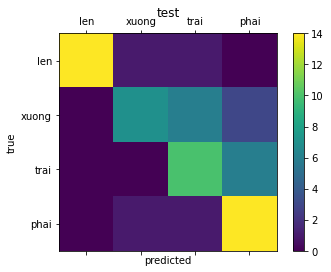

In [23]:
plotCM(y_true, y_predict, labels)

In [24]:
print(n_test)

{'len': 16, 'xuong': 16, 'trai': 16, 'phai': 16}


## Test âm thu từ micro

In [25]:
"""
print("Testing testDataSet")
n_correct = {'len': 0, 'xuong': 0, 'trai': 0, 'phai': 0}
y_testTrue = []
y_testPredict = []
labels = ['trai', 'len', 'xuong', 'phai']
for true_cname in testClass_names:
    for O in testDataSet[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_testTrue.append(true_cname)
        y_testPredict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))
"""

Testing testDataSet


NameError: name 'testClass_names' is not defined

In [ ]:
#np.around(models['trong'].transmat_, 2)

In [ ]:
"""
for cname in testClass_names:
    print('Accuracy:', cname, n_correct[cname]/n_testDataSet[cname])
print('All Accuracy:', sum(n_correct.values())/sum(n_testDataSet.values()))
"""

In [ ]:
#plotCM(y_testTrue, y_testPredict, labels)